# Train script for Hybrid VAE model

### imports

In [1]:
%matplotlib inline

from torch.autograd import Variable
from torch import optim
from torch.utils.data import DataLoader
import torch

import sys
sys.path.append("../../Modules")
sys.path.append("../../Datasets")

# local imports
from train import train
from helpers import kl_loss,nll_loss,mse_loss,kl_loss_multi
from models import HybridVAESmall
from ToyDatasets.timeSeries import Sinusoids

## Define dataset loader

In [2]:
batch_size = 32
num_steps = 16
dataset_size = 5000
num_classes = 10

data_loader = DataLoader(Sinusoids(num_steps,virtual_size=dataset_size,quantization=num_classes),batch_size=batch_size,shuffle=True)
valid_data_loader = DataLoader(Sinusoids(num_steps,virtual_size=dataset_size,quantization=num_classes),batch_size=batch_size,shuffle=True)

batch_loader = iter(data_loader)
valid_batch_loader = iter(valid_data_loader)

## Define model

In [3]:
model = HybridVAESmall(input_size=1,conv_size=150,rnn_size=150,latent_size=64,output_size=num_classes,use_softmax=True)
print("Number of trainable parameters {}".format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# test forward pass
try:
    initial_batch = batch_loader.next()
    x = Variable(initial_batch).type(torch.FloatTensor).transpose(1,0)
    test,_,_ = model(x)
    assert (test.shape[0] == x.shape[0] and test.shape[1] == x.shape[1] and test.shape[2] == num_classes)
    print("Forward pass succesfull")
except:
    print("Error in forward pass. Output should have shape: {} but had {}".format(x.contiguous().view(-1).shape,test.view(-1).shape))

Number of trainable parameters 833848
Forward pass succesfull


## Define optimizer and loss

In [4]:
learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode="min",factor=0.5,verbose=True,cooldown=5)

## Run trainer


Train (1 2%) elbo: -2.5627 r_loss: -1.9559 kl: 1049.8873 aux_loss: -2.0229 beta 0.00e+00
Valid (1 2%) elbo: -2.1474 r_loss: -1.6657 kl: 4020.1809 aux_loss: -1.6056 beta 0.00e+00

Train (2 4%) elbo: -2.0462 r_loss: -1.4953 kl: 586.3840 aux_loss: -1.4373 beta 2.04e-04
Valid (2 4%) elbo: -1.9409 r_loss: -1.4391 kl: 434.4148 aux_loss: -1.3769 beta 2.04e-04

Train (3 6%) elbo: -1.5874 r_loss: -1.1542 kl: 259.3317 aux_loss: -1.0909 beta 4.08e-04
Valid (3 6%) elbo: -1.5490 r_loss: -1.1135 kl: 268.1347 aux_loss: -1.0869 beta 4.08e-04

Train (4 8%) elbo: -1.2609 r_loss: -0.8791 kl: 202.0116 aux_loss: -0.8604 beta 6.12e-04
Valid (4 8%) elbo: -1.1454 r_loss: -0.7962 kl: 194.8960 aux_loss: -0.7661 beta 6.12e-04

Train (5 10%) elbo: -1.1503 r_loss: -0.7716 kl: 171.5564 aux_loss: -0.7955 beta 8.16e-04
Valid (5 10%) elbo: -1.0881 r_loss: -0.7120 kl: 201.6970 aux_loss: -0.7048 beta 8.16e-04

Train (6 12%) elbo: -1.0515 r_loss: -0.6835 kl: 152.6744 aux_loss: -0.7076 beta 1.02e-03
Valid (6 12%) elbo: -


Train (47 94%) elbo: -1.0726 r_loss: -0.5133 kl: 40.8075 aux_loss: -0.5870 beta 9.39e-03
Valid (47 94%) elbo: -1.1366 r_loss: -0.5590 kl: 41.2298 aux_loss: -0.6351 beta 9.39e-03

Train (48 96%) elbo: -1.0697 r_loss: -0.5079 kl: 40.4032 aux_loss: -0.5809 beta 9.59e-03
Valid (48 96%) elbo: -1.0752 r_loss: -0.5241 kl: 38.8667 aux_loss: -0.5943 beta 9.59e-03

Train (49 98%) elbo: -1.0738 r_loss: -0.5093 kl: 39.7639 aux_loss: -0.5831 beta 9.80e-03
Valid (49 98%) elbo: -1.1062 r_loss: -0.5353 kl: 39.3943 aux_loss: -0.6167 beta 9.80e-03

Train (50 100%) elbo: -1.0783 r_loss: -0.5092 kl: 39.3977 aux_loss: -0.5838 beta 1.00e-02
Valid (50 100%) elbo: -1.2902 r_loss: -0.6674 kl: 39.9032 aux_loss: -0.7458 beta 1.00e-02


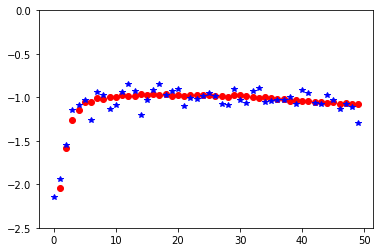

In [5]:
# use at least 50 iterations to get good results
train(data_loader,valid_data_loader,model,optimizer,scheduler,loss_fn=nll_loss,kl_loss_fn=kl_loss,n_iters=50,use_softmax=True,max_beta=1e-2,print_every=1,plot_pred=False)

In [6]:
#torch.save(model.state_dict(),"Saved_models/HybridVAE_nll.pt")